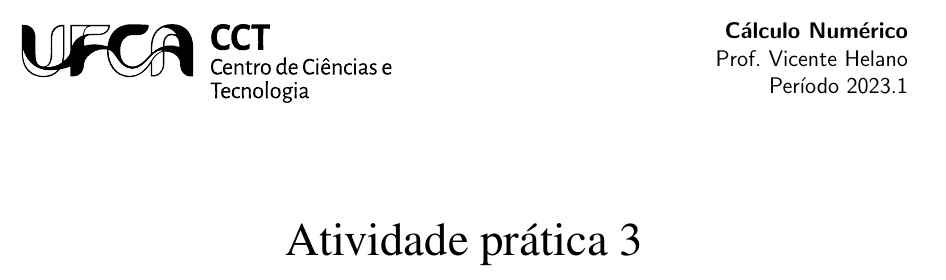

### **Nome:** Seu Nome Aqui

<BR CLEAR="right" />
<img src="https://ars.els-cdn.com/content/image/1-s2.0-S1047320317301803-gr2.jpg" align="left" alt="Ponte Binacional Franco-Brasileira" style="padding-right: 10pt;" width="50%">

<p style="padding-top: 7pt;"><span style="font-size: 250%; font-weight: bold; color: #00006D;">S</span>abe quando a gente tira do baú um álbum de família, mas quando viramos uma página, eis que alguns pedaços de uma fotografia ficam grudados nele?
Há um tempo atrás, muita gente experimentou esta situação.
Nos dias de hoje, isto pode ser transposto para o contexto das fotos digitais, por exemplo, quando desejamos recuperar uma foto antiga deteriorada que foi digitalizada ou remover algum objeto indesejado presente na cena.
Este tipo de problema é o conhecido como **retoque digital**.
Neste projeto, vocês irão implementar e tentar melhorar um algoritmo simples de retoque digital que se resume em resolver um sistema de equações algébricas lineares.

## Imagens digitais

Uma *imagem digital* pode ser vista como uma matriz $\mathbf{P} = \left[ p_{ij} \right]$, $m\times n$, onde cada elemento $p_{ij}$ é denominado *pixel*.
Os cantos superior esquerdo e inferior direito de uma imagem correspondem aos pixels $p_{0,0}$ e $p_{m-1,n-1}$.
Existem diversas formas de se representar a cor de um pixel.
No sistema conhecido como RGB (do inglês, *Red*, *Green*, *Blue*), a cor de um pixel é representada usando três canais: <font color="red">vermelho</font>, <font color="green">verde</font> e <font color="blue">azul</font>.
Supondo cada canal representado com 8 bits, teremos $2^8 = 256$ valores distintos por canal.
A combinação dos três canais possibilita a criação de 256 x 256 x 256 cores, o que é algo em torno de 16 milhões de cores.

Matematicamente, a cor de um pixel $p_{i,j}$ pode ser representada por um vetor de cor $p_{i,j} = \left( r, g, b\right)$, onde $0 \le r,g,b \le 255$.
Quanto maior o valor de um canal, maior será a intensidade dele na cor final obtida.
Algumas exemplos de combinações de canais são:

* $(255,0,0)$: <font color="#ff0000">vermelho</font>
* $(0,255,0)$: <font color="#00ff00">verde</font>
* $(0,0,255)$: <font color="#0000ff">azul</font>
* $(255,255,0)$: <font color="#ffff00">amarelo</font>
* $(0,255,255)$: <font color="#00ffff">ciano</font>
* $(255,0,255)$ <font color="#ff00ff">magenta</font>
* $(0,0,0)$: <font color="#000000">preto</font>
* $(127,127,127)$: <font color="#777777">cinza médio</font>
* $(255,255,255)$: <font color="#ffffff">branco</font> (não dá para ver, não é? Selecione o texto ao lado.)

Em Python, fica fácil manipular imagens usando a biblioteca `imageio`:

In [ ]:
import imageio

Este pacote permite carregar imagens armazenadas localmente ou acessíveis pela internet.

Por exemplo, podemos carregar uma imagem a partir de um endereço URL:

In [ ]:
exemplo = imageio.v2.imread('https://www.ufca.edu.br/portal/wp-content/themes/ufca/assets/images/logo-ufca.png')

o resultado do comando acima é um arranjo 2D semelhante ao `numpy.array`.

Depois de carregar a imagem, podemos exibir suas dimensões (o que chamamos de *resolução espacial*) e a quantidade de canais presentes:

In [ ]:
m,n,nc = exemplo.shape
m,n,nc

Os números acima significam que a imagem possui 63 pixels de altura, 555 pixels de largura e 4 canais de cores.
Esse quarto canal é conhecido como canal *alfa*, usado para representar níveis de transparência.
Considerando o que precisamos fazer nesta tarefa, este canal pode ser ignorado.

Como a imagem agora é um `array`, podemos acessar um pixel $p_{i,j}$ usando indexação. Por exemplo, o conteúdo do pixel $p_{2,3}$ é

In [ ]:
R = exemplo[2,3,0]
G = exemplo[2,3,1]
B = exemplo[2,3,2]
R,G,B

Para exibir a imagem, podemos usar a `matplotlib`:

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10)) # ajusta as dimensões de saída
plt.imshow(exemplo) # cria um gráfico cujo fundo é a imagem
plt.show() # exibe o gráfico criado'

Também é possível abrir imagens armazenadas localmente ou no [Google Drive](https://towardsdatascience.com/the-2-step-guide-to-upload-images-in-google-colab-b51348e882e4).

## Algoritmo de retoque

O objetivo de um *algoritmo de retoque* é substituir pixels indesejados de uma foto baseando-se nas cores de seus pixels vizinhos.
Um bom retoque deve produzir uma imagem nova com emendas imperceptíveis entre as regiões que foram mantidas intactas e aquelas recém preenchidas.
A imagem abaixo ilustra o resultado de um algoritmo de retoque.
À esquerda está a imagem original, ao centro estão indicados os pixels que se deseja alterar, e ao lado direito está o resultado final.

![](https://raw.githubusercontent.com/Mugichoko445/Fast-Digital-Image-Inpainting/images/example_2.png)
Fonte: https://github.com/Mugichoko445/Fast-Digital-Image-Inpainting

Um algoritmo simples de retoque funciona do seguinte modo.
Suponha que $\mathbf{P} = \left[p_{i,j}\right]$ é a imagem original.
Primeiramente, vocês devem indicar quais pixels de $\mathbf{P}$ desejam retocar.
Esta fase é a que toma mais tempo, pois ainda é feita manualmente.
Para tanto, criamos uma imagem auxiliar $\mathbf{M} = [m_{i,j}]$, conhecida como *máscara*, com as mesmas dimensões de $\mathbf{P}$.
Nela, indicamos em preto os pixels que desemamos remover.
Se a cor armazenada em $m_{i,j}$ for diferente de preto, então o pixel $p_{i,j}$ deverá ser preservado e nada precisa ser feito com relação a ele.
Caso contrário, sua cor será recalculada como a seguir.

Suponha que $p_{i,j}$ é um pixel que precisa ser alterado, ou seja, $m_{i,j} = (0,0,0)$.
Portanto, sua vizinhança é forma pelos pixels:

$$
\begin{array}{|c|c|c|}
\hline
p_{i-1,j-1} & p_{i-1,j} & p_{i-1,j+1}\\
\hline
p_{i,j-1} & p_{i,j} & p_{i,j+1}\\
\hline
p_{i+1,j-1} & p_{i+1,j} & p_{i+1,j+1}\\
\hline
\end{array}
$$

A ideia básica do algoritmo é expressar a nova cor de $p_{i,j}$ como a média aritmética das cores de seus vizinhos, isto é,

$$
\begin{align*}
(r_{i,j},g_{i,j},b_{i,j}) = \frac{1}{8} & \Bigl( (r_{i-1,j-1},g_{i-1,j-1},b_{i-1,j-1}) + (r_{i-1,j},g_{i-1,j},b_{i-1,j}) + (r_{i-1,j+1},g_{i-1,j+1},b_{i-1,j+1}) + (r_{i,j-1},g_{i,j-1},b_{i,j-1})\ + \Bigr.
\\
& \Bigl. \quad +\ (r_{i,j+1},g_{i,j+1},b_{i,j+1}) + (r_{i+1,j-1},g_{i+1,j-1},b_{i+1,j-1}) + (r_{i+1,j},g_{i+1,j},b_{i+1,j}) + (r_{i+1,j+1},g_{i+1,j+1},b_{i+1,j+1}) \Bigr)
\end{align*}
$$

Por conveniência, considere apenas o canal R (vermelho). Nesse caso, podemos escrever:

$$
-r_{i-1,j-1} - r_{i-1,j} - r_{i-1,j+1} - r_{i,j-1} + 8 r_{i,j} - r_{i,j+1} - r_{i+1,j-1} - r_{i+1,j} - r_{i+1,j+1} = 0
$$

Se um dos pixels vizinhos de $p_{i,j}$ precisar ser preservado, sua cor deve ser tratada como constante. Neste caso, esta parcela deverá ser transferida para a direita da equação.

Supondo um total de $N$ pixels indesejados, a aplicação da equação acima em cada um deles resultará em três sistemas lineares com $N$ equações e $N$ incógnitas, um para cada canal RGB, todos com a mesma matriz de coeficientes:

$$
\mathbf{A}\mathbf{x}_r = \mathbf{b}_r, \quad
\mathbf{A}\mathbf{x}_g = \mathbf{b}_g, \quad \text{e} \quad
\mathbf{A}\mathbf{x}_b = \mathbf{b}_b.
$$

Após resolver esses sistemas, basta atualizar as cores dos pixels indesejados com aquelas que foram calculadas e voilà, sua imagem terá sido retocada!

**Exemplo.** Considere a imagem $4 \times 4$ exibida abaixo. Para facilitar a compreensão, os pixels estão representados de forma ampliada.

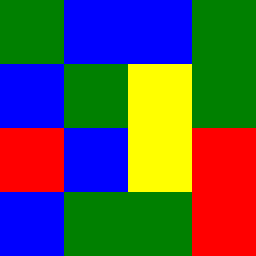

Suponha que se deseja substituir os pixels em amarelo usando o algoritmo de retoque descrito anteriormente.
Primeiramente, utilizando o software [Gimp](https://www.gimp.org/), criamos a máscara $\mathbf{M}$, ilustrada  abaixo:

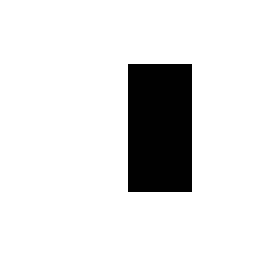

Ela será utilizada para determinar quais pixels serão recalculados.
Nesse caso, há dois desses pixels: $p_{1,2}$ e $p_{2,2}$.
Com isso, teremos que montar e resolver três sistemas de equações lineares com duas equações cada.
A seguir, ilustraremos a montagem do sistema considerando apenas o canal de vermelho.

Com efeito, para o primeiro pixel indesejado $p_{1,2}$, temos as equação

$$
-r_{0,1} - r_{0,2} - r_{0,3} - r_{1,0} + 8 r_{1,2} - r_{1,3} - r_{2,0} - r_{2,2} - r_{2,3} = 0
$$

Já para o pixel $p_{2,2}$, obtemos

$$
-r_{1,1} - r_{1,2} - r_{1,3} - r_{2,1} + 8 r_{2,2} - r_{2,3} - r_{3,1} - r_{3,2} - r_{3,3} = 0
$$

Como todos os demais pixels devem ser preservados (são constantes), podemos reescrever as equações acima como:

\begin{align*}
8 r_{1,2} - r_{2,2} &= r_{0,1} + r_{0,2} + r_{0,3} + r_{1,0} + r_{1,3} + r_{2,0} + r_{2,3}\\
- r_{1,2} + 8 r_{2,2} &= r_{1,1} + r_{1,3} + r_{2,1} + r_{2,3} + r_{3,1} + r_{3,2} + r_{3,3}
\end{align*}

que matricialmente fica:

$$
\begin{bmatrix}
 8 & - 1\\
-1 & 8
\end{bmatrix}
\begin{bmatrix}
r_{1,2}\\
r_{2,2}
\end{bmatrix}
=
\begin{bmatrix}
r_{0,1} + r_{0,2} + r_{0,3} + r_{1,0} + r_{1,3} + r_{2,0} + r_{2,3}\\
r_{1,1} + r_{1,3} + r_{2,1} + r_{2,3} + r_{3,1} + r_{3,2} + r_{3,3}
\end{bmatrix}
$$

Procedendo de modo análogo, montamos os sistemas para os canais G e B:

$$
\begin{bmatrix}
 8 & - 1\\
-1 & 8
\end{bmatrix}
\begin{bmatrix}
g_{1,2}\\
g_{2,2}
\end{bmatrix}
=
\begin{bmatrix}
g_{0,1} + g_{0,2} + g_{0,3} + g_{1,0} + g_{1,3} + g_{2,0} + g_{2,3}\\
g_{1,1} + g_{1,3} + g_{2,1} + g_{2,3} + g_{3,1} + g_{3,2} + g_{3,3}
\end{bmatrix}
$$

$$
\begin{bmatrix}
 8 & - 1\\
-1 & 8
\end{bmatrix}
\begin{bmatrix}
b_{1,2}\\
b_{2,2}
\end{bmatrix}
=
\begin{bmatrix}
b_{0,1} + b_{0,2} + b_{0,3} + b_{1,0} + b_{1,3} + b_{2,0} + b_{2,3}\\
b_{1,1} + b_{1,3} + b_{2,1} + b_{2,3} + b_{3,1} + b_{3,2} + b_{3,3}
\end{bmatrix}
$$

Resolvendo esses sistemas e atualizando a imagem com os novos valores de cores calculados para os pixels indesejados, teremos a imagem retocada.

## Descrição da tarefa

A tarefa de vocês é remover a coleira presente na foto a seguir.

In [ ]:
original = imageio.v2.imread('https://drive.google.com/uc?id=1YilrrkC-c0ofAbgjkCs1hYwi1le5m92i')

plt.figure(figsize=(10,10))
plt.imshow(original)
plt.show()

## Construção da máscara

O primeiro passo é carregar a máscara indicando os pixels a serem removidos.

In [ ]:
mascara = imageio.v2.imread("Imagens/mascara.png")

plt.figure(figsize=(10,10))
plt.imshow(mascara)
plt.show()

## Montagem do sistema

Na prática, a montagem de um sistema de equações $\mathbf{A}\mathbf{x} = \mathbf{b}$ geralmente é dividida em duas etapas: (i) numeração das incógnitas e (ii) construção da matriz $\mathbf{A}$ e do vetor $\mathbf{b}$.

(a) Agora, vocês devem realizar a numeração das incógnitas.
Isto deve ser feito com o auxílio de uma matriz $\mathbf{I}$ com $N$ linhas e $N$ colunas, onde $N$ é a quantidade de pixels a serem recalculados.
Cada elemento `I[i,j]` indicará se o pixel $p_{i,j}$ é indesejado ou deve ser mantido constante.
Utilizem o valor `I[i,j] = -1` para indicar um pixel fixo.
Caso contrário, armazenem em `I[i,j]` o número da equação/incógnita associada ao pixel indesejado $p_{i,j}$.
Ao final, exibam a quantidade de pixels a serem retocados.

In [ ]:
import numpy as np

def numera(M):
    m,n = M.shape[0:2]
    I = np.zeros((m,n), dtype=int)
    
    # TODO: numeração das equações
    
    
    return I

(b) Com a matrix $\mathbf{I}$ pronta, é possível montar os sistemas de cada canal de cor.
Lembrem-se que a matriz dos coeficientes é a mesma para os canais.
Apenas os vetores independentes serão distintos.

In [1]:
# Escreva o código desta etapa aqui.
def montagem(P,M):
    # numera as equações
    I = numera(M)
    
    # calcula a quantidade de pixels indesejados
    N = np.count_nonzero(I >= 0)
    
    # TODO: constroi a matriz e os vetores independentes
    A  = np.eye(N)
    br = np.zeros((N,))
    bg = np.zeros((N,))
    bb = np.zeros((N,))
                    
    return I,A,br,bg,bb

## Aplicação do retoque

(c) Com os sistemas montados, basta resolvê-los empregando o método de sua escolha. Só não vale usar as implementações disponíveis na `numpy`, `scipy` e correlatos. Vocẽs devem implementar um método para resolução de sistemas lineares.

In [ ]:
def retoque(P,M):
    # montagem do sistema
    I,A,br,bg,bb = montagem(P,M)
    
    # TODO: cálculo das novas cores
    
    
    
    # TODO: construção da imagem retocada
    
    
    
    return retocada

In [ ]:
# Calcula e exibe a imagem retocada
retocada = retoque(original,mascara)

plt.figure(figsize=(15,10))
plt.imshow(retocada)
plt.show()

## Saiba mais

* Esta atividade foi baseada no artigo [Fast Digital Image Inpainting](https://www.inf.ufrgs.br/~oliveira/pubs_files/inpainting.pdf), de Manuel M. Oliveira, Brian Bowen, Richard McKenna e Yu-Sung Chang.

* A imagem do cachorro com uma coleira foi extraída do site: https://www.mendotapet.com/

2023 Vicente Helano  
UFCA | Centro de Ciências e Tecnologia